# <center>Градиентный бустинг для пуассоновской регрессии</center>

In [1]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

**Задание.** Используйте свою реализацию алгоритма градиентного бустинга для задачи регрессии. Добавьте в неё пуассоновскую функцию потерь и сравните результаты обучения. Обратите внимание, что название класса в текущем файле было изменено.

- Методы `mse_grad` и `poisson_grad` должны возвращать градиенты функции потерь для обычной и пуассоновской регрессий.
- Метод `mse` должен вычислять среднеквадратичную ошибку по всей выборке (используйте функцию `sklearn.metrics.mean_squared_error`.
- В переменную `loss_` будем записывать величины среднеквадратичной ошибки на каждом шаге алгоритма.
- В методе `fit` необходимо инициализировать начальное приближение как среднее значение `y` для всех объектов выборки, если функция потерь `loss='mse'`, или натуральный логарифм среднего значения, если функция потерь `loss='poisson'`. Сохраните начальное приближение в переменную `self.b_initial`, оно пригодится на этапе предсказаний.
- На каждом шаге обучения необходимо вычислить остатки композиции, затем на остатках обучить дерево регрессии с `max_depth` и `random_state` класса и добавить предсказания текущего дерева к имеющимся с шагом `learning_rate`.
- Метод `predict` должен возвращать значение целевой переменной для каждого из объектов. Обратите внимание, что в случае, когда `loss='poisson'` начальное приближение &ndash; логарифм среднего. Аналогично, псевдоостатки являются логарифмированной величиной. Таким образом, полученный результат необходимо потенцировать.

In [2]:
class GradientBoostingRegressor(BaseEstimator):
    
    @staticmethod
    def mse_grad(y_true, y_pred):
        return - (y_true - y_pred)
    
    @staticmethod
    def poisson_grad(y_true, y_pred):
        return np.exp(y_pred) - y_true
    
    @staticmethod
    def mse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred)
    
    def __init__(self, n_estimators=10, learning_rate=0.01, loss='mse', 
                 max_depth=3, random_state=17):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss_name = loss
        self.max_depth = max_depth
        self.random_state = random_state
        
        self.residuals_ = []
        self.trees_ = []
        self.loss_ = []
            
    def fit(self, X, y):
        self.b_initial = np.mean(y) if self.loss_name == "mse" else np.log(np.mean(y))
        y_pred = np.full(len(y), self.b_initial)
        
        for t in range(self.n_estimators):
            residual = -self.mse_grad(y, y_pred) if self.loss_name == "mse" else -self.poisson_grad(y, y_pred)
            dt = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            dt.fit(X, residual)
            dt_predict = dt.predict(X)
            y_pred = y_pred + self.learning_rate * dt_predict
            self.loss_.append(self.mse(y, y_pred))
            self.residuals_.append(residual)
            self.trees_.append(dt)
        
    def predict(self, X):
        matrix = np.array([self.learning_rate * tree.predict(X) for tree in self.trees_])
        result = np.sum(matrix, axis=0) + self.b_initial
        return result if self.loss_name == "mse" else np.exp(result)

Обучите обычный и пуассоновский алгоритмы на следующей выбоке:

In [3]:
X = np.random.uniform(-4*np.pi, 4*np.pi, size=20000).reshape(-1, 1)

f = lambda t: 2*(1 - np.abs(t)/(4*np.pi))*np.abs(np.cos(t))

lam = np.exp(f(X)).flatten()
y = np.random.poisson(lam=lam)

In [4]:
gbm_mse = GradientBoostingRegressor(learning_rate=0.01, loss='mse', n_estimators=1000)
gbm_poi = GradientBoostingRegressor(learning_rate=0.01, loss='poisson', n_estimators=1000)

Выведите графики зависимости среднеквадратичной ошибки от итерации для обоих алгоритмов.

In [5]:
gbm_mse.fit(X, y)
gbm_poi.fit(X, y)

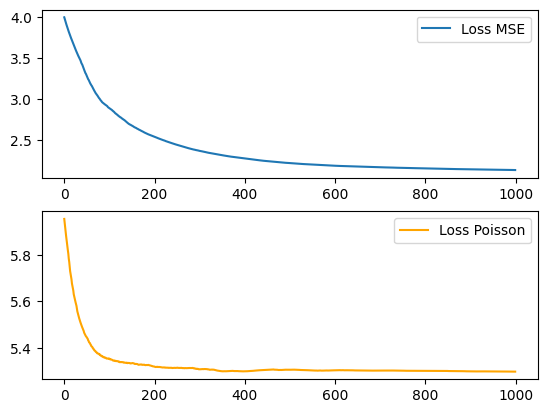

In [6]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gbm_mse.loss_, label="Loss MSE")
ax2.plot(gbm_poi.loss_, color="orange", label="Loss Poisson")
ax1.legend()
ax2.legend()
plt.show()

Результаты алгоритмов:

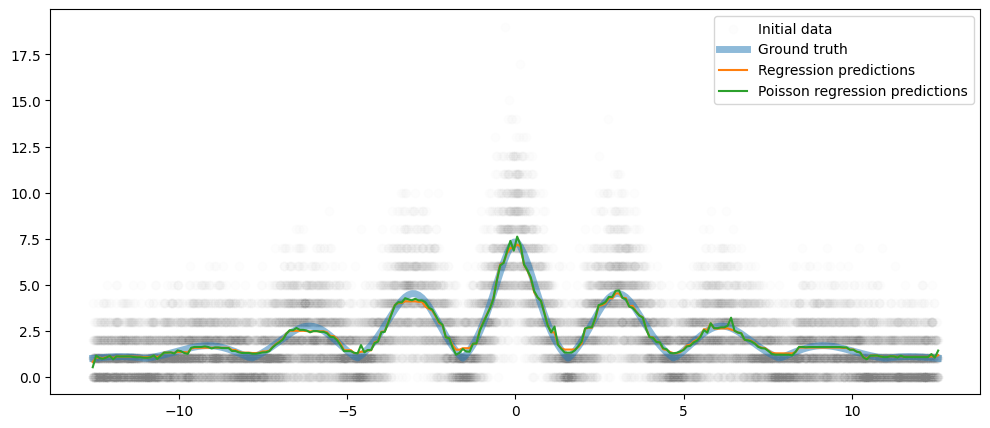

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X.flatten(), y, color='grey', alpha=0.01, label='Initial data')

t = np.linspace(-4*np.pi, 4*np.pi, num=250)
ax.plot(t, np.exp(f(t)), label='Ground truth', linewidth=5, alpha=0.5)

yhat_mse = gbm_mse.predict(t.reshape(-1, 1))
ax.plot(t, yhat_mse, label='Regression predictions')

yhat_poi = gbm_poi.predict(t.reshape(-1, 1))
ax.plot(t, yhat_poi, label='Poisson regression predictions')

ax.legend()
plt.show()